<a href="https://colab.research.google.com/github/raihanewubd/12leadHeartEEG/blob/main/AI_Lab_05a_Pretrained_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rifat963/pumpkin")

print("Path to dataset files:", path)

100%|██████████| 675M/675M [00:10<00:00, 70.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/rifat963/pumpkin/versions/2


In [6]:
import shutil

src = '/root/.cache/kagglehub/datasets/rifat963/pumpkin/versions/2'
dst = '/content'

shutil.copytree(src, dst, dirs_exist_ok=True)

'/content'

In [19]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models


from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt



In [4]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Data transforms for training and validation

In [7]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ]),
}

In [9]:
data_dir = '/content/Augmented/Augmented'  # Update this with your local path
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                              shuffle=True, num_workers=4)
               for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [12]:
# List of pretrained models to experiment with
pretrained_models = {
    'resnet18': models.resnet18(pretrained=True),
    #'resnet50': models.resnet50(pretrained=True),
    #'efficientnet_b0': models.efficientnet_b0(pretrained=True)
}

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [17]:
num_classes = len(class_names)
print(f"Number of classes:{num_classes}")
num_epochs = 2  # Adjust as needed

Number of classes:5


In [15]:
def train_and_evaluate_model(model, model_name):
    # Modify final layer according to the architecture
    if model_name.startswith('resnet'):
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
    elif 'efficientnet' in model_name:
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_ftrs, num_classes)

    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    print(f"\nTraining model: {model_name}")

    # Training loop
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

    # After training, evaluate on the validation set:
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []  # to store probabilities for ROC curve

    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probabilities = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probabilities.cpu().numpy())

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)

    # Classification report and confusion matrix
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    print("Confusion Matrix:")
    print(confusion_matrix(all_labels, all_preds))

    # ROC curve for each class (One-vs-Rest)
    fpr = {}
    tpr = {}
    roc_auc = {}
    # Binarize the output labels for multi-class ROC computation
    labels_binarized = label_binarize(all_labels, classes=range(num_classes))

    plt.figure()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(labels_binarized[:, i], all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i],
                 label=f'ROC curve for {class_names[i]} (area = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random chance
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves for {model_name}')
    plt.legend(loc="lower right")
    plt.show()


Training model: resnet18
Epoch 1/2


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.3830 Acc: 0.8679
Val Loss: 0.5187 Acc: 0.8421
Epoch 2/2
Train Loss: 0.2498 Acc: 0.9098
Val Loss: 0.5585 Acc: 0.8271

Classification Report:
                     precision    recall  f1-score   support

Bacterial Leaf Spot       0.70      0.87      0.78        76
       Downy Mildew       0.81      0.86      0.83        79
       Healthy Leaf       0.92      0.88      0.90        80
     Mosaic Disease       0.91      0.94      0.93        72
     Powdery_Mildew       0.83      0.63      0.72        92

           accuracy                           0.83       399
          macro avg       0.83      0.84      0.83       399
       weighted avg       0.83      0.83      0.83       399

Confusion Matrix:
[[66  3  4  0  3]
 [ 4 68  0  0  7]
 [10  0 70  0  0]
 [ 0  2  0 68  2]
 [14 11  2  7 58]]


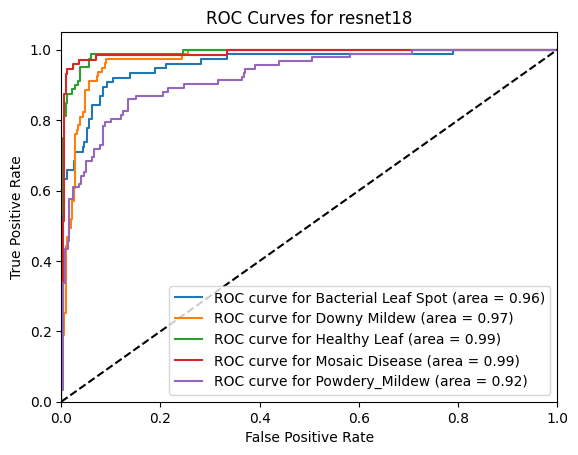

In [20]:
# Loop through each pretrained model, train and evaluate
for name, model in pretrained_models.items():
    train_and_evaluate_model(model, name)